In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
import skimage.exposure
import pandas as pd
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
CLEANED = os.path.join(DIR, 'preps', 'CH1', 'thumbnail_cleaned')
MASKED = os.path.join(DIR, 'preps', 'thumbnail_masked')
files = sorted(os.listdir(INPUT))

In [2]:
def linnorm(img, limit, dt):
    flat = img.flatten()
    hist, bins = np.histogram(flat, limit + 1)
    cdf = hist.cumsum()  # cumulative distribution function
    cdf = limit * cdf / cdf[-1]  # normalize
    # use linear interpolation of cdf to find new pixel values
    img_norm = np.interp(flat, bins[:-1], cdf)
    img_norm = np.reshape(img_norm, img.shape)
    return img_norm.astype(dt)

def get_index(array, list_of_arrays):
    for j, a in enumerate(list_of_arrays):
        if np.array_equal(array, a):
            return j
    return None

strip_max=270; strip_min=2   # the range of width for the stripe
def remove_strip(src):
    projection=np.sum(src,axis=0)/10000.
    diff=projection[1:]-projection[:-1]
    loc,=np.nonzero(diff[-strip_max:-strip_min]>50)
    mval=np.max(diff[-strip_max:-strip_min])
    no_strip=np.copy(src)
    fe = 0
    if loc.shape[0]>0:
        loc=np.min(loc)
        from_end=strip_max-loc
        fe = -from_end - 2
        no_strip[:,fe:]=0 # mask the strip
    return no_strip, fe

def find_contours(mask):
    area2 = 0
    area3 = 0
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return len(contours)

def pad_with_black(img):
    r,c = img.shape
    pad = 100
    img[0:pad,:] = 0
    img[:,c-pad:c]=0
    img[r-pad:r,:]=0
    img[:,0:pad]=0
    return img


In [3]:
bads = ['000.tif','062.tif', '276.tif', '296.tif', '371.tif', '378.tif', '389.tif', '390.tif', '392.tif', '393.tif',
 '394.tif', '395.tif', '400.tif', '405.tif', '406.tif', '407.tif', '408.tif', '472.tif', '476.tif',
 '478.tif', '479.tif', '481.tif', '482.tif', '483.tif', '484.tif', '485.tif']

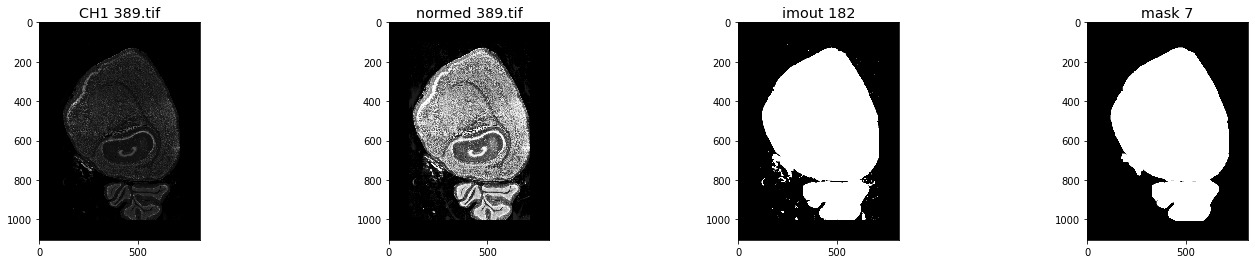

In [4]:
def fix_with_fill(img, limit, dt):
    no_strip, fe = remove_strip(img)
    if fe != 0:
        img[:,fe:]=0 # mask the strip
    img = (img/256).astype(dt)
    h_src = linnorm(img, limit , dt)
    med = np.median(h_src)
    h, im_th = cv2.threshold(h_src, med, limit, cv2.THRESH_BINARY)
    im_floodfill = im_th.copy()
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = im_th | im_floodfill_inv
    stencil = np.zeros(img.shape).astype('uint8')
    
    #dilation = cv2.dilate(stencil,kernel,iterations = 2)
    kernel = np.ones((10,10),np.uint8)
    eroded = cv2.erode(im_out,kernel,iterations = 1)

    
    contours, hierarchy = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    totalarea = im_out.shape[0] * im_out.shape[1]
    
    lc = []
    c1 = max(contours, key = cv2.contourArea)
    lc.append(c1)
    area1 = cv2.contourArea(c1)
        
    idx = get_index(c1, contours)  # 2
    contours.pop(idx)
    if len(contours) > 0:
        cX = max(contours, key = cv2.contourArea)
        area2 = cv2.contourArea(cX)
        if area2 > (area1 * 2000.00125):
            lc.append(cX)
            #cv2.fillPoly(stencil, lc, 255)
        idx = get_index(cX, contours)  # 2
        contours.pop(idx)
        
    if len(contours) > 0:
        cX = max(contours, key = cv2.contourArea)
        area3 = cv2.contourArea(cX)
        if area3 > (area1 * 20000.00125):
            lc.append(cX)
            #cv2.fillPoly(stencil, lc, 100)
        idx = get_index(cX, contours)  # 2
        contours.pop(idx)  
    if len(contours) > 0:
        cX = max(contours, key = cv2.contourArea)
        area4 = cv2.contourArea(cX)
        if area4 > (area3 * 20000.00125):
            lc.append(cX)
            #cv2.fillPoly(stencil, lc, 100)
        idx = get_index(cX, contours)  # 2
        contours.pop(idx)  
        
        
    cv2.fillPoly(stencil, lc, 255)
    
    if len(contours) > 0:
        cv2.fillPoly(stencil, contours, 0)

    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
    dilation = cv2.dilate(stencil,kernel,iterations = 2)
    return h_src, im_out, dilation, 0

limit = 250
dt = np.uint8
file = '389.tif'
infile = os.path.join(INPUT, file)
img = io.imread(infile)
imgpad = pad_with_black(img)
normed = linnorm(imgpad, 45000, np.uint16)
h_src, im_out, mask, area = fix_with_fill(imgpad, limit, dt)
contours1 = find_contours(im_out)
contours2 = find_contours(mask)

ncols = 4
fig, ax = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False)
plt.style.use('classic')
ax[0].set_title('CH1 {}'.format(file))
ax[0].imshow(img, cmap="gray")
ax[1].set_title('normed {}'.format(file))
ax[1].imshow(normed, cmap="gray")
ax[2].set_title('imout {}'.format(contours1))
ax[2].imshow(im_out, cmap="gray")
ax[3].set_title('mask {}'.format(contours2))
ax[3].imshow(mask, cmap="gray")
# swap the 10 and the six below if the images are wider than height
fig.set_size_inches(np.array([6*ncols, 4 ]), forward=True)
plt.show()